In [139]:
# %%
# 1. Initialization
# ===========================
import pandas as pd
import numpy as np
import pulp
from pulp import PULP_CBC_CMD
import matplotlib.pyplot as plt
import networkx as nx

# Working directory
# datadir = "/content/"
datadir = "/Users/rvieira/Documents/Master/vt1-energy-investment-model/data/"

# print("Default GLPK path:", pulp.GLPK().path)
# print(pulp.listSolvers())


In [ ]:
# %%
# 2. Data
# ===========================

# Load demand data and scale
demand_data = pd.read_csv(
    datadir + 'processed/load-summer.csv',
    delimiter=';',
    parse_dates=['time'],
    header=0
)
# Scale to desired level (e.g., factor 100 as previously discussed)
demand_data['value'] = pd.to_numeric(demand_data['value']) * 100

# Create a DataFrame for time-varying demand at bus 5
demand_time_series = pd.DataFrame({
    'time': demand_data['time'],
    'bus': 5,
    'pd': demand_data['value'],
})
demand_time_series['time'] = pd.to_datetime(demand_time_series['time'])

# Renewable generation data
solar_data = pd.read_csv(datadir + 'processed/solar-summer.csv', parse_dates=['time'], delimiter=';',header=0)
wind_data = pd.read_csv(datadir + 'processed/wind-summer.csv', parse_dates=['time'], delimiter=';',header=0)

# Create generator time series DataFrames
# Assign IDs and buses as per the new configuration:
# Nuclear: id=1, bus=1
# Gas: id=2, bus=2
# Wind: id=3, bus=3 (using wind_data)
# Solar: id=4, bus=4 (using solar_data)
# Wind Battery: id=5, bus=6
# Solar Battery: id=6, bus=7

# Nuclear
nuclear_gen = pd.DataFrame({
    'time': solar_data['time'],
    'id': 1,
    'bus': 1,
    'pmax': 300,
    'pmin': 0,
    'gencost': 10
})

# Gas
gas_gen = pd.DataFrame({
    'time': solar_data['time'],
    'id': 2,
    'bus': 2,
    'pmax': 250,
    'pmin': 0,
    'gencost': 80
})

# Wind
wind_gen = pd.DataFrame({
    'time': wind_data['time'],
    'id': 3,
    'bus': 3,
    'pmax': wind_data['value']/10,  
    'pmin': 0,
    'gencost': 5
})

# Solar
solar_gen = pd.DataFrame({
    'time': wind_data['time'],
    'id': 4,
    'bus': 4,
    'pmax': solar_data['value']/10,
    'pmin': 0,
    'gencost': 5
})
I 
# Wind Battery at bus 6
wind_storage = pd.DataFrame({
    'time': wind_data['time'],
    'id': 6,
    'bus': 6,
    'pmax': 40,
    'pmin': -40,
    'gencost': 0,
    
    'emax':100,
    'einitial':0,
    'eta':0.99
})

solar_storage = pd.DataFrame({
    'time': solar_data['time'],
    'id': 7,
    'bus': 7,
    'pmax': 40,
    'pmin': -40,
    'gencost': 0,
    
    'emax':100,
    'einitial':0,
    'eta':0.99
})

# Combine all generators and storage, fill NaNs 
gen_time_series = pd.concat([nuclear_gen, gas_gen, wind_gen, solar_gen, wind_storage, solar_storage], ignore_index=True)
gen_time_series = gen_time_series.fillna(0)

# Load branch and bus data (already processed and updated as requested)
branch = pd.read_csv(datadir + "processed/branch2.csv")
bus = pd.read_csv(datadir + "processed/bus2.csv")

# Rename columns to lowercase
for df in [branch, bus]:
    df.columns = df.columns.str.lower()

# Create IDs for branches
branch['id'] = np.arange(1, len(branch) + 1)

# Calculate susceptance
branch['sus'] = 1 / branch['x']

# Print to verify
# print(bus)
# print(branch)
print(gen_time_series)
# print(demand_time_series)
# print(gas_gen)
# print(nuclear_gen)
# print(gas_gen)
# print(wind_storage)

# print(gen_time_series.head())
# print(gen_time_series['id'].unique())  # Check generator IDs
# print(gen_time_series['time'].min(), gen_time_series['time'].max())  # Check time range

# print(demand_time_series['time'].min(), demand_time_series['time'].max())  # Check time range
# print(demand_time_series['time'].unique())  # Check unique time steps

# print(branch[['fbus', 'tbus']])

# print(bus['bus_i'].dtype)
# print(branch['fbus'].dtype, branch['tbus'].dtype)
# print(demand_time_series['bus'].dtype)

                    time  id  bus   pmax  pmin  gencost   emax  einitial   eta
0    2023-08-06 00:00:00   1    1  300.0     0       10    0.0       0.0  0.00
1    2023-08-06 01:00:00   1    1  300.0     0       10    0.0       0.0  0.00
2    2023-08-06 02:00:00   1    1  300.0     0       10    0.0       0.0  0.00
3    2023-08-06 03:00:00   1    1  300.0     0       10    0.0       0.0  0.00
4    2023-08-06 04:00:00   1    1  300.0     0       10    0.0       0.0  0.00
...                  ...  ..  ...    ...   ...      ...    ...       ...   ...
1003 2023-08-12 19:00:00   7    7   40.0   -40        0  100.0       0.0  0.99
1004 2023-08-12 20:00:00   7    7   40.0   -40        0  100.0       0.0  0.99
1005 2023-08-12 21:00:00   7    7   40.0   -40        0  100.0       0.0  0.99
1006 2023-08-12 22:00:00   7    7   40.0   -40        0  100.0       0.0  0.99
1007 2023-08-12 23:00:00   7    7   40.0   -40        0  100.0       0.0  0.99

[1008 rows x 9 columns]


In [147]:
print(generation_over_time[generation_over_time.duplicated(subset='time', keep=False)])
print(storage_over_time[storage_over_time.duplicated(subset='time', keep=False)])

                    time  id  node     gen
0    2023-08-06 00:00:00   1     1   0.000
1    2023-08-06 01:00:00   1     1   0.000
2    2023-08-06 02:00:00   1     1   0.000
3    2023-08-06 03:00:00   1     1   0.000
4    2023-08-06 04:00:00   1     1   0.000
...                  ...  ..   ...     ...
1003 2023-08-12 19:00:00   7     7  40.000
1004 2023-08-12 20:00:00   7     7  40.000
1005 2023-08-12 21:00:00   7     7   0.000
1006 2023-08-12 22:00:00   7     7  18.454
1007 2023-08-12 23:00:00   7     7   0.546

[1008 rows x 4 columns]
     storage_id                time          E  P_charge  P_discharge
0             6 2023-08-06 00:00:00   0.000000       0.0        0.000
1             6 2023-08-06 01:00:00   0.000000       0.0        0.000
2             6 2023-08-06 02:00:00   0.000000       0.0        0.000
3             6 2023-08-06 03:00:00   0.000000       0.0        0.000
4             6 2023-08-06 04:00:00   0.000000       0.0        0.000
..          ...                 ...    

## Function 

Parameters:
- gen_time_series (pd.DataFrame): Generator data with time series.
- branch (pd.DataFrame): Branch data.
- bus (pd.DataFrame): Bus data.
- demand_time_series (pd.DataFrame): Demand data with time series.
- eta (float): Storage efficiency (0 < eta <= 1).
- E_max (float): Maximum energy storage capacity (MWh).
- P_max (float): Maximum charging/discharging power (MW).
- time_steps (list of pd.Timestamp): List of time steps to consider.
- E_initial (float, optional): Initial energy in the storage (MWh).
- delta_t (float): Duration of each time step in hours.


In [148]:
# 3. Function
# ===========================

def dcopf(gen_time_series, branch, bus, demand_time_series, delta_t=1):
    import pulp
    from pandas.tseries.offsets import DateOffset
    import numpy as np
    import pandas as pd

    DCOPF = pulp.LpProblem("DCOPF", pulp.LpMinimize)

    # Identify storage and non-storage units
    # Storage units are those with emax > 0
    storage_data = gen_time_series[gen_time_series['emax'] > 0]
    S = storage_data['id'].unique()
    non_storage_data = gen_time_series[gen_time_series['emax'] == 0]
    G = non_storage_data['id'].unique()

    N = bus['bus_i'].values
    T = sorted(demand_time_series['time'].unique())
    next_time = T[-1] + DateOffset(hours=delta_t)
    extended_T = list(T) + [next_time]

    # Create GEN variables for non-storage generators
    GEN = {}
    for g in G:
        gen_rows = gen_time_series[(gen_time_series['id'] == g)]
        # We assume the same pmin/pmax/gencost across all T or a row for each T
        for t in T:
            row = gen_rows.loc[gen_rows['time'] == t]
            if row.empty:
                print(f"Error: Generator {g} has no data for time {t}.")
                return None
            pmin = row['pmin'].values[0]
            pmax = row['pmax'].values[0]
            GEN[g, t] = pulp.LpVariable(f"GEN_{g}_{t}_var", lowBound=pmin, upBound=pmax)

    # Voltage angle variables
    THETA = {(i, t): pulp.LpVariable(f"THETA_{i}_{t}_var", lowBound=None) for i in N for t in T}

    # FLOW variables
    FLOW = {}
    for idx, row in branch.iterrows():
        i = int(row['fbus'])  
        j = int(row['tbus'])
        for t in T:
            FLOW[i, j, t] = pulp.LpVariable(f"FLOW_{i}_{j}_{t}_var", lowBound=None)

    # DC Power Flow Constraints
    for idx_branch, row in branch.iterrows():
        i = int(row['fbus'])
        j = int(row['tbus'])
        susceptance = row['sus']
        for t in T:
            DCOPF += FLOW[i, j, t] == susceptance * (THETA[i, t] - THETA[j, t]), \
                    f"Flow_Constraint_{i}_{j}_Time_{t}"

    # Storage Variables and Constraints
    # For each storage unit, extract parameters from gen_time_series
    P_charge = {}
    P_discharge = {}
    E = {}

    for s in S:
        # Assume storage parameters are time-invariant and take from first row
        s_row = gen_time_series[(gen_time_series['id'] == s)].iloc[0]
        E_max = s_row['emax']
        E_initial = s_row['einitial']
        eta = s_row['eta']
        P_max = s_row['pmax']  # positive direction
        # pmin is negative pmax, so max charge/discharge capacity is abs(pmin)

        # Create storage variables
        for t in T:
            P_charge[s, t] = pulp.LpVariable(f"P_charge_{s}_{t}_var", lowBound=0, upBound=P_max)
            P_discharge[s, t] = pulp.LpVariable(f"P_discharge_{s}_{t}_var", lowBound=0, upBound=P_max)

        for t in extended_T:
            E[s, t] = pulp.LpVariable(f"E_{s}_{t}_var", lowBound=0, upBound=E_max)

        # Initial SoC constraint
        DCOPF += E[s, T[0]] == E_initial, f"Initial_Storage_SoC_{s}"

        # Storage dynamics
        for idx_t, t in enumerate(T):
            next_t = extended_T[idx_t + 1]
            DCOPF += E[s, next_t] == E[s, t] + eta * P_charge[s, t] * delta_t - (1 / eta) * P_discharge[s, t] * delta_t, \
                    f"Storage_Dynamics_{s}_Time_{t}"

        # Optional: Final SoC constraint (if desired)
        DCOPF += E[s, extended_T[-1]] == E_initial, f"Final_Storage_SoC_{s}"

    # Slack bus angle = 0
    slack_bus = 1
    for t in T:
        DCOPF += THETA[slack_bus, t] == 0, f"Slack_Bus_Angle_Time_{t}"

    # Objective Function: sum generation costs (non-storage + storage if any gencost)
    DCOPF += pulp.lpSum(
        gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'gencost'].values[0] * GEN[g, t]
        for g in G for t in T
    ), "Total_Generation_Cost"
    # Note: Storage cost is typically zero as defined.

    # Power Balance Constraints
    for t in T:
        for i in N:
            # Sum of generation at bus i (non-storage)
            gen_sum = pulp.lpSum(
                GEN[g, t]
                for g in G
                if gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'bus'].values[0] == i
            )

            # Demand at bus i
            demand = demand_time_series.loc[(demand_time_series['bus'] == i) & (demand_time_series['time'] == t), 'pd']
            demand_value = demand.values[0] if not demand.empty else 0

            # Add storage contributions for this bus
            storages_at_bus_i = gen_time_series.loc[(gen_time_series['bus'] == i) & (gen_time_series['emax'] > 0), 'id'].unique()
            if len(storages_at_bus_i) > 0:
                gen_sum += pulp.lpSum(P_discharge[s, t] - P_charge[s, t] for s in storages_at_bus_i)

            flow_out = pulp.lpSum(FLOW[i, j, t] for j in branch.loc[branch['fbus'] == i, 'tbus'])
            flow_in = pulp.lpSum(FLOW[j, i, t] for j in branch.loc[branch['tbus'] == i, 'fbus'])

            # Power balance constraint
            DCOPF += gen_sum - demand_value + flow_in - flow_out == 0, f"Power_Balance_Bus_{i}_Time_{t}"

    # Flow limits
    for idx_branch, row in branch.iterrows():
        i = row['fbus']
        j = row['tbus']
        rate_a = row['ratea']
        for t in T:
            DCOPF += FLOW[i, j, t] <= rate_a, f"Flow_Limit_{i}_{j}_Upper_Time_{t}"
            DCOPF += FLOW[i, j, t] >= -rate_a, f"Flow_Limit_{i}_{j}_Lower_Time_{t}"

    # Solve the problem
    DCOPF.solve(pulp.PULP_CBC_CMD(msg=True))

    # Check status
    if pulp.LpStatus[DCOPF.status] != 'Optimal':
        print(f"Optimization did not find an optimal solution. Status: {pulp.LpStatus[DCOPF.status]}")
        return None

    # Extracting Results
    # Non-storage generation
    generation = pd.DataFrame([
        {
            'time': t,
            'id': g,
            'node': gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'bus'].values[0],
            'gen': pulp.value(GEN[g, t])
        }
        for g in G for t in T
    ])

    # Also add storage net output as "generation" for reporting, if desired
    # Storage doesn't have GEN variables but we can represent net output (discharge - charge)
    storage_gen_list = []
    for s in S:
        s_bus = gen_time_series.loc[gen_time_series['id'] == s, 'bus'].iloc[0]
        for t in T:
            storage_gen_list.append({
                'time': t,
                'id': s,
                'node': s_bus,
                'gen': pulp.value(P_discharge[s, t]) - pulp.value(P_charge[s, t])
            })
    storage_generation = pd.DataFrame(storage_gen_list)

    # Combine non-storage and storage generation
    generation = pd.concat([generation, storage_generation], ignore_index=True)

    angles = pd.DataFrame([
        {'time': t, 'bus': i, 'theta': pulp.value(THETA[i, t])}
        for i in N for t in T
    ])

    flows_df = pd.DataFrame([
        {'time': t, 'from_bus': i, 'to_bus': j, 'flow': pulp.value(FLOW[i, j, t])}
        for (i, j, t) in FLOW
    ])

    # Extract Storage Results
    storage_list = []
    for s in S:
        for idx_t, tt in enumerate(extended_T):
            E_val = pulp.value(E[s, tt])
            Pch = pulp.value(P_charge[s, tt]) if tt in T else None
            Pdis = pulp.value(P_discharge[s, tt]) if tt in T else None
            storage_list.append({
                'storage_id': s,
                'time': tt,
                'E': E_val,
                'P_charge': Pch,
                'P_discharge': Pdis
            })

    storage_df = pd.DataFrame(storage_list)

    # Shift E values if you want E at the start of the interval
    storage_corrected = []
    for s_id, group in storage_df.groupby('storage_id'):
        group = group.sort_values('time').reset_index(drop=True)
        group['E'] = group['E'].shift(-1)
        group = group.iloc[:-1]  # remove last row with NaN
        storage_corrected.append(group)

    storage_df = pd.concat(storage_corrected, ignore_index=True)

    total_cost = pulp.value(DCOPF.objective)
    status = pulp.LpStatus[DCOPF.status]

    return {
        'generation': generation,
        'angles': angles,
        'flows': flows_df,
        'storage': storage_df,
        'cost': total_cost,
        'status': status
    }

In [149]:
# 4. Solve with Storage (Updated)
# ===========================

# gen_time_series now contains storage parameters for units with emax > 0
# demand_time_series, bus, and branch are already loaded and processed
# No separate storage_units dictionary is needed now.

# Extract and sort unique time steps from gen_time_series
time_steps = sorted(gen_time_series['time'].unique())

# Run the DCOPF without the storage_units parameter, as it's no longer needed
results = dcopf(
    gen_time_series=gen_time_series,
    branch=branch,
    bus=bus,
    demand_time_series=demand_time_series,
    delta_t=1  # assuming 1-hour time steps
)

# Check and Extract Results
if results and results['status'] == 'Optimal':
    print("Optimization was successful.")
    print(f"Total Cost: {results['cost']}")

    # Extract Results
    generation_over_time = results['generation']
    storage_over_time = results['storage']
    flows_over_time = results['flows']

    # Display the first few rows of each result DataFrame
    print("\nGeneration Over Time:")
    print(generation_over_time.head())

    print("\nStorage States Over Time:")
    print(storage_over_time.head())

    print("\nFlows Over Time:")
    print(flows_over_time.head())
else:
    print("Optimization failed or no optimal solution found.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rvieira/Library/Caches/pypoetry/virtualenvs/vt1-energy-investment-model-XXwssDO0-py3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/1m/qt1qgmf14_gb0hy_4g7323hc0000gn/T/3179c55bd7bf4bb8a23651db5a065858-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/1m/qt1qgmf14_gb0hy_4g7323hc0000gn/T/3179c55bd7bf4bb8a23651db5a065858-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8241 COLUMNS
At line 27062 RHS
At line 35299 BOUNDS
At line 40342 ENDATA
Problem MODEL has 8236 rows, 5042 columns and 18148 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2520 (-5716) rows, 3631 (-1411) columns and 10181 (-7967) elements
Perturbing problem by 0.001% of 80 - largest nonzero change 9.7854373e-06 ( 4.5822337e-05%) - largest zero change 9.7833487e-06
0  Obj 0 Primal inf 21

Total Cost: 35514.60785


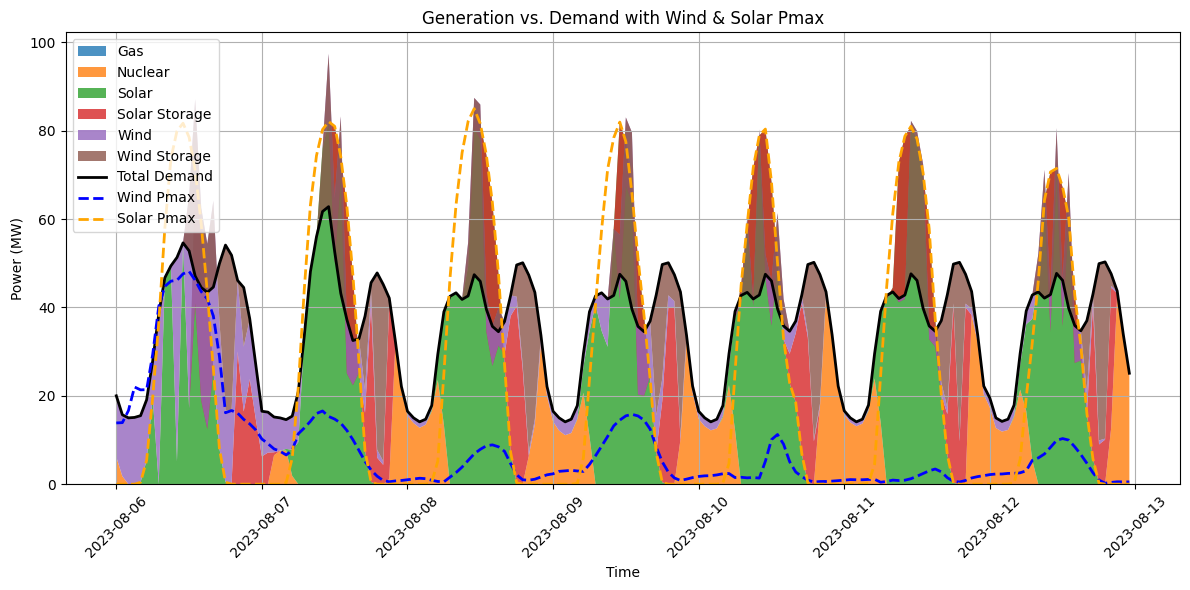

In [152]:
# 5. Visualisation
# ===========================

if results and results['status'] == 'Optimal':
    # Extract relevant results
    generation = results['generation']
    storage = results['storage']
    flows = results['flows']
    angles = results['angles']
    cost = results['cost']

    # Print total cost
    print(f"Total Cost: {cost}")

    # Identify generator names if desired (adjust IDs accordingly)
    id_to_name = {
        1: 'Nuclear',
        2: 'Gas',
        3: 'Wind',
        4: 'Solar',
        6: 'Wind Storage',
        7: 'Solar Storage'
    }

    # Pivot generation data to get a stacked area format
    gen_pivot = generation.copy()
    gen_pivot['name'] = gen_pivot['id'].map(id_to_name).fillna('Unknown')
    gen_pivot = gen_pivot.pivot(index='time', columns='name', values='gen').fillna(0).sort_index()

    # Demand series
    demand_series = demand_time_series.set_index('time')['pd'].reindex(gen_pivot.index, fill_value=0)

    # Plot Generation vs. Demand (stacked area)
    # Extract Wind / Solar Pmax (assuming wind id=3)
    wind_pmax = gen_time_series[gen_time_series['id'] == 3][['time', 'pmax']].drop_duplicates()
    wind_pmax = wind_pmax.set_index('time')['pmax'].reindex(gen_pivot.index, fill_value=0)
    solar_pmax = gen_time_series[gen_time_series['id'] == 4][['time', 'pmax']].drop_duplicates()
    solar_pmax = solar_pmax.set_index('time')['pmax'].reindex(gen_pivot.index, fill_value=0)

    # Prepare columns for stacked area (exclude storage if it exists)
    stacked_cols = [col for col in gen_pivot.columns if col not in ['Storage']]

    plt.figure(figsize=(12, 6))
    
    plt.stackplot(gen_pivot.index, [gen_pivot[col] for col in stacked_cols], labels=stacked_cols, alpha=0.8)
    plt.plot(demand_series.index, demand_series.values, label='Total Demand', color='black', linewidth=2)
    plt.plot(wind_pmax.index, wind_pmax.values, label='Wind Pmax', color='blue', linestyle='--', linewidth=2)
    plt.plot(solar_pmax.index, solar_pmax.values, label='Solar Pmax', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Power (MW)')
    plt.title('Generation vs. Demand with Wind & Solar Pmax')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
